In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, kT_N
from rikabplotlib.plot_utils import newplot, plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation
from pyspecter.Observables import Observable

2024-04-20 10:05:11.885984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
# Parameters 
R = 0.5
this_dir = ""
this_study = "cmsopendata"
lr = 0.005


dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 15000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open

Max # of particles: 132


In [3]:
# We need to define a line Observable
# To do this, we need a sampler, an initializer (optional), and a projector (optional)

def sample_line(params, N, seed):

    key = random.PRNGKey(seed)
    ones = random.uniform(key, shape=(N,), minval=0., maxval=1)
    
    # Compute x and y coordinates of the sampled points on the line
    x = params["Length"] * ones
    y = params["Length"] * jnp.zeros_like(ones)
    
    event = jnp.column_stack([jnp.ones(N) / N, x, y])
    
    return event 

def initialize(event, N, seed):
    return {"Length" : R/2}

def project(params):

    radius = params["Length"]
    params["Length"] = jnp.maximum(radius, 0.)
    return params

_splineliness = Observable(sample_line, name = "spLineliness", initializer=initialize, projector=project)
_splineliness.compile(test_events = dataset[:10])

Compiling with vmap after jit


In [4]:
def sample_circle(params, N, seed):

    key = random.PRNGKey(seed)
    thetas = random.uniform(key, shape=(N,), minval=0., maxval=2*jnp.pi)
    
    # Compute x and y coordinates of the sampled points on the circle
    x = params["Radius"] * jnp.cos(thetas)
    y = params["Radius"] * jnp.sin(thetas)
    
    event = jnp.column_stack([jnp.ones(N) / N, x, y])
    
    return event

def initialize(event, N, seed):
    return {"Radius" : R/2}

def project(params):

    radius = params["Radius"]
    params["Radius"] = jnp.maximum(radius, 0.)
    return params

_springiness = Observable(sample_circle, name = "spRinginess", initializer=initialize, projector=project)
_springiness.compile(test_events = dataset[:10])

Compiling with vmap after jit


In [5]:
def sample_disk(params, N, seed):

    key = random.PRNGKey(seed)
    random_numbers = random.uniform(key, shape=(N,2), minval=0., maxval=1)
    rads = jnp.sqrt(random_numbers[:,0])
    thetas = 2 * jnp.pi * random_numbers[:,1]
    
    # Compute x and y coordinates of the sampled points on the circle
    x = params["Radius"] * rads * jnp.cos(thetas)
    y = params["Radius"] * rads * jnp.sin(thetas)
    
    event = jnp.column_stack([jnp.ones(N) / N, x, y])
    
    return event

def initialize(event, N, seed):
    return {"Radius" : R/2}

def project(params):

    radius = params["Radius"]
    params["Radius"] = jnp.maximum(radius, 0.)
    return params

_sdiskiness = Observable(sample_disk, name = "spDiskiness", initializer=initialize, projector=project)
_sdiskiness.compile(test_events = dataset[:10])

Compiling with vmap after jit


Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
[[1.         0.01366513 0.10827078]]
[[ 0.15161219  0.01069719  0.07065222]
 [ 0.09346332  0.0269614   0.11085293]
 [ 0.06472161 -0.02137307  0.12948176]
 [ 0.04705965  0.0213167   0.08306357]
 [ 0.04240936  0.02828271  0.09639928]
 [ 0.03687273  0.03888305  0.15375254]
 [ 0.03420918 -0.04170652 -0.42728665]
 [ 0.03183314  0.08315157  0.11700198]
 [ 0.02986718 -0.01256719 -0.38867596]
 [ 0.02842939  0.03656959  0.13393328]
 [ 0.02603438 -0.04872494  0.03602001]
 [ 0.02565427 -0.00988377 -0.39635351]
 [ 0.02465076  0.05160304  0.10851452]
 [ 0.02439846  0.01625974  0.09895107]
 [ 0.02371201 -0.04608398  0.04793093]
 [ 0.01863866 -0.00847017  0.15069696]
 [ 0.01473709 -0.09070059 -0.43118504]
 [ 0.01452677  0.01711191 -0.38039258]
 [ 0.01334912  0.01679483  0.13815114]
 [ 0.01218668  0.02423968  0.12380573]
 [ 0.01205189 -0.12547751 -0.35375026]
 [ 0.01181274  0.0484058   0.11342785]
 [ 0.01148091 -

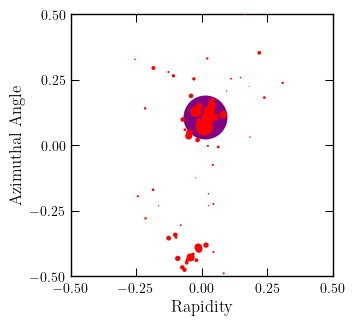

In [6]:
def build_n_spronginess(n):

    def sample(params, N, seed):
        event = params["Points"]
        return event
    
    def initialize(events, N, seed):

        return {"Points" : kT_N(events, N, 0.5)}
    
    def project(params):

        event = params["Points"]

        temp = jnp.copy(event)
        zs = event[:,0]
        num_particles = event.shape[0]

        cnt_n = jnp.arange(num_particles)

        u = jnp.sort(zs, axis = -1)[::-1]
        v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
        w = v[jnp.sum(u > v, axis = -1) - 1]
        temp2 = temp.at[:,0].set(jnp.maximum(zs - w, 0))

        # temp = temp.at[:,:,0].set(jnp.maximum(temp[:,:,0], 0))
        # return temp

        return {"Points" : temp2}
    
    O = Observable(sample, name = f"{n}-sPronginess", initializer=initialize, projector=project)
    O.skip_vmap_initialization = True
    return O

_1spronginess = build_n_spronginess(1)
_1spronginess.compile(test_events = dataset[:10], N_sample = 1)

_2spronginess = build_n_spronginess(2)
_2spronginess.compile(test_events = dataset[:10], N_sample = 2)

_3spronginess = build_n_spronginess(3)
_3spronginess.compile(test_events = dataset[:10], N_sample = 3)


# Test
params_3 = _1spronginess.initializer(dataset[:2], 1, 0)
event = params_3["Points"][0]
print(event)
print(dataset[0])

fig, ax = newplot("column")
plot_event(ax, event, R, color = "purple")
plot_event(ax, dataset[0], R)

specter = SPECTER()

emds = specter.spectralEMD(params_3["Points"], dataset[:2])
print(emds)


In [7]:
emds, params, loss_history, params_history = _splineliness.compute(dataset, learning_rate= lr, early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/line_emds.npy", emds)
np.save("test_data/line_params.npy", params)
np.save("test_data/line_loss_history.npy", loss_history)
np.save("test_data/line_params_history.npy", params_history)

spLineliness: Epoch 0 of 150, Mean Loss:  9.458e-03, Time:  26.258s ( 26.258s), Early Stopping:  0.000
spLineliness: Epoch 1 of 150, Mean Loss:  8.510e-03, Time:  51.433s ( 25.174s), Early Stopping:  0.000
spLineliness: Epoch 2 of 150, Mean Loss:  8.616e-03, Time:  72.815s ( 21.382s), Early Stopping:  0.000
spLineliness: Epoch 3 of 150, Mean Loss:  8.338e-03, Time:  94.237s ( 21.423s), Early Stopping:  0.000
spLineliness: Epoch 4 of 150, Mean Loss:  7.982e-03, Time:  115.768s ( 21.531s), Early Stopping:  0.000
spLineliness: Epoch 5 of 150, Mean Loss:  7.744e-03, Time:  137.131s ( 21.363s), Early Stopping:  0.000
spLineliness: Epoch 6 of 150, Mean Loss:  8.388e-03, Time:  158.761s ( 21.630s), Early Stopping:  0.000
spLineliness: Epoch 7 of 150, Mean Loss:  7.628e-03, Time:  180.012s ( 21.250s), Early Stopping:  0.000
spLineliness: Epoch 8 of 150, Mean Loss:  7.459e-03, Time:  201.357s ( 21.345s), Early Stopping:  0.000
spLineliness: Epoch 9 of 150, Mean Loss:  7.197e-03, Time:  222.686s

In [8]:
emds, params, loss_history, params_history = _springiness.compute(dataset, learning_rate= lr , early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/ring_emds.npy", emds)
np.save("test_data/ring_params.npy", params)
np.save("test_data/ring_loss_history.npy", loss_history)
np.save("test_data/ring_params_history.npy", params_history)

spRinginess: Epoch 0 of 150, Mean Loss:  6.304e-02, Time:  25.612s ( 25.612s), Early Stopping:  0.000
spRinginess: Epoch 1 of 150, Mean Loss:  6.149e-02, Time:  51.363s ( 25.750s), Early Stopping:  0.000
spRinginess: Epoch 2 of 150, Mean Loss:  5.353e-02, Time:  72.924s ( 21.561s), Early Stopping:  0.000
spRinginess: Epoch 3 of 150, Mean Loss:  5.570e-02, Time:  94.553s ( 21.629s), Early Stopping:  0.000
spRinginess: Epoch 4 of 150, Mean Loss:  5.293e-02, Time:  120.708s ( 26.154s), Early Stopping:  0.000
spRinginess: Epoch 5 of 150, Mean Loss:  4.652e-02, Time:  143.765s ( 23.057s), Early Stopping:  0.000
spRinginess: Epoch 6 of 150, Mean Loss:  4.436e-02, Time:  165.275s ( 21.510s), Early Stopping:  0.000
spRinginess: Epoch 7 of 150, Mean Loss:  4.476e-02, Time:  186.786s ( 21.511s), Early Stopping:  0.000
spRinginess: Epoch 8 of 150, Mean Loss:  3.999e-02, Time:  208.359s ( 21.573s), Early Stopping:  0.000
spRinginess: Epoch 9 of 150, Mean Loss:  3.986e-02, Time:  229.885s ( 21.526s

In [9]:
print(np.nanmean(loss_history, axis = 1))
for i in range(91):
    print(np.mean(params_history[i]["Radius"], axis = 0))

[6.30373535e-02 6.14890786e-02 5.35250068e-02 5.57041577e-02
 5.29334675e-02 4.65245635e-02 4.43620054e-02 4.47581427e-02
 3.99869931e-02 3.98603586e-02 3.66121402e-02 3.52894658e-02
 3.31991486e-02 2.99966708e-02 2.71717779e-02 2.68210087e-02
 2.52601647e-02 2.40683231e-02 2.15494259e-02 2.16197221e-02
 2.05110474e-02 1.90846148e-02 1.78238910e-02 1.65967215e-02
 1.57798483e-02 1.49954254e-02 1.39239691e-02 1.35291405e-02
 1.23973352e-02 1.21258415e-02 1.15157909e-02 1.04801409e-02
 1.04993747e-02 1.01221440e-02 9.36821438e-03 9.01330957e-03
 8.51986989e-03 8.58501670e-03 8.43836083e-03 7.87561595e-03
 7.99390038e-03 7.83035965e-03 7.20870069e-03 7.36525919e-03
 7.49172599e-03 6.63013351e-03 7.21725446e-03 7.00612241e-03
 7.19625192e-03 6.99769118e-03 6.98531981e-03 6.88809912e-03
 6.95110651e-03 6.93902429e-03 6.72478520e-03 6.70428763e-03
 6.83626293e-03 6.81679963e-03 6.34407604e-03 6.64327974e-03
 6.74230042e-03 6.83956303e-03 6.68188066e-03 6.77799676e-03
 6.76776530e-03 6.142645

In [10]:
emds, params, loss_history, params_history = _sdiskiness.compute(dataset, learning_rate= lr, early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/disk_emds.npy", emds)
np.save("test_data/disk_params.npy", params)
np.save("test_data/disk_loss_history.npy", loss_history)
np.save("test_data/disk_params_history.npy", params_history)


spDiskiness: Epoch 0 of 150, Mean Loss:  2.483e-02, Time:  25.443s ( 25.443s), Early Stopping:  0.000
spDiskiness: Epoch 1 of 150, Mean Loss:  2.209e-02, Time:  50.523s ( 25.080s), Early Stopping:  0.000
spDiskiness: Epoch 2 of 150, Mean Loss:  1.884e-02, Time:  72.085s ( 21.562s), Early Stopping:  0.000
spDiskiness: Epoch 3 of 150, Mean Loss:  2.490e-02, Time:  93.610s ( 21.525s), Early Stopping:  0.000
spDiskiness: Epoch 4 of 150, Mean Loss:  1.610e-02, Time:  115.108s ( 21.498s), Early Stopping:  0.000
spDiskiness: Epoch 5 of 150, Mean Loss:  1.887e-02, Time:  136.711s ( 21.603s), Early Stopping:  0.000
spDiskiness: Epoch 6 of 150, Mean Loss:  1.649e-02, Time:  158.301s ( 21.590s), Early Stopping:  0.000
spDiskiness: Epoch 7 of 150, Mean Loss:  1.621e-02, Time:  179.863s ( 21.562s), Early Stopping:  0.000
spDiskiness: Epoch 8 of 150, Mean Loss:  1.652e-02, Time:  201.252s ( 21.389s), Early Stopping:  0.000
spDiskiness: Epoch 9 of 150, Mean Loss:  1.201e-02, Time:  222.794s ( 21.542s

In [11]:
emds1, params1, loss_history1, params_history1 = _1spronginess.compute(dataset, learning_rate= lr, early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/1sprong_emds.npy", emds1)
np.save("test_data/1sprong_params.npy", params1)
np.save("test_data/1sprong_loss_history.npy", loss_history1)
np.save("test_data/1sprong_params_history.npy", params_history1)

emds2, params2, loss_history2, params_history2 = _2spronginess.compute(dataset, learning_rate= lr, early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/2sprong_emds.npy", emds2)
np.save("test_data/2sprong_params.npy", params2)
np.save("test_data/2sprong_loss_history.npy", loss_history2)
np.save("test_data/2sprong_params_history.npy", params_history2)

emds3, params3, loss_history3, params_history3 = _3spronginess.compute(dataset, learning_rate= lr, early_stopping=25, N_sample = 50, finite_difference=False)

# save
np.save("test_data/3sprong_emds.npy", emds3)
np.save("test_data/3sprong_params.npy", params3)
np.save("test_data/3sprong_loss_history.npy", loss_history3)
np.save("test_data/3sprong_params_history.npy", params_history3)


1-sPronginess: Epoch 0 of 150, Mean Loss:  7.574e+01, Time:  26.053s ( 26.053s), Early Stopping:  0.000
1-sPronginess: Epoch 1 of 150, Mean Loss:  6.042e+01, Time:  47.867s ( 21.814s), Early Stopping:  0.000
1-sPronginess: Epoch 2 of 150, Mean Loss:  5.955e+03, Time:  69.784s ( 21.917s), Early Stopping:  0.000
1-sPronginess: Epoch 3 of 150, Mean Loss:  6.062e-01, Time:  91.495s ( 21.711s), Early Stopping:  0.000
1-sPronginess: Epoch 4 of 150, Mean Loss:  5.970e-01, Time:  113.295s ( 21.799s), Early Stopping:  0.000
1-sPronginess: Epoch 5 of 150, Mean Loss:  5.783e-01, Time:  135.132s ( 21.838s), Early Stopping:  0.000
1-sPronginess: Epoch 6 of 150, Mean Loss:  5.850e-01, Time:  156.855s ( 21.723s), Early Stopping:  0.000
1-sPronginess: Epoch 7 of 150, Mean Loss:  6.042e-01, Time:  178.534s ( 21.678s), Early Stopping:  0.000
1-sPronginess: Epoch 8 of 150, Mean Loss:  6.030e-01, Time:  200.276s ( 21.743s), Early Stopping:  0.000
1-sPronginess: Epoch 9 of 150, Mean Loss:  6.020e-01, Time:

In [12]:
print(params_history[0]["Length"].shape)
plt.hist(params["Length"], bins=np.linspace(0,0.5,100), histtype="step", label="Final")

KeyError: 'Length'